# 0. Imports

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Data Loading

In [55]:
path = '../data/processed/pgm-dataset-processado.csv'

df = pd.read_csv(path)

## 1.1 - Balanceamento das classes

A fim de evitar o alto consumo de tokens pela LLM vamos reduzir o número de textos das classes com mais de 100 exemplos.

In [56]:
len(df[df['setorDestino'] == 'Fiscal'])

6686

In [57]:
setores_destino = df['setorDestino'].unique()

N = 100
sampled_dfs_by_setor = []

for setor in setores_destino:
    # Recupera todos os textos do setor
    df_setor = df[df['setorDestino'] == setor]

    # Verifica se o setor tem mais de 100 textos:
    if len(df_setor) > N:
        sampled_setor = df_setor.sample(n = N)
    else:
        sampled_setor = df_setor.sample(frac = 1)
    
    sampled_dfs_by_setor.append(sampled_setor)

sampled_df = pd.concat(sampled_dfs_by_setor)
print(f'Shape do novo DataFrame: {sampled_df.shape}')
print(f'Distribuição de classes do novo DataFrame:\n\n{sampled_df['setorDestino'].value_counts()}')

Shape do novo DataFrame: (700, 8)
Distribuição de classes do novo DataFrame:

setorDestino
Saúde             100
Administrativa    100
Fiscal            100
Contabilidade     100
Judicial          100
Patrimonial       100
Meio Ambiente     100
Name: count, dtype: int64


## 1.2 - Removendo stopwords de 'teorTexto'

In [58]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        words = word_tokenize(text, language='portuguese')
        stop_words = set(stopwords.words('portuguese'))
        filtered_words = [word for word in words if word.isalnum() and word not in stop_words]

        return ' '.join(filtered_words)
    return ''

sampled_df['teorTexto_processado'] = sampled_df['teorTexto'].apply(preprocess_text)

## 1.3 - Removendo colunas desnecessárias

In [59]:
sampled_df.head(3)

,teorTexto,setorDestino,tipoAviso,orgaoJulgador,assuntos,documentos,anexos,classeProcesso,teorTexto_processado
12529,PODER JUDICIÁRIOTRIBUNAL DE JUSTIÇA DO ESTADO ...,Saúde,Intimação,4ª VFP da Com. Natal,12511;12491,Certidão de decurso de prazo;Contrarrazões;Ato...,ADITAMENTO - PETIÇÃO INICIAL - ELIANE- SAUDE;P...,7,poder judiciáriotribunal justiça estado rio gr...
9808,PODER JUDICIÁRIO ESTADO DO RIO GRANDE DO NORTE...,Saúde,Citação,2ª VIJ da Com. Natal,12513,Despacho;Petição Incidental;Despacho;Contestaç...,notaTecnica-242159.pdf - notaTecnica-242159;SI...,1706,poder judiciário estado rio grande norte 2ª va...
11553,PODER JUDICIÁRIO DO ESTADO DO RIO GRANDE DO NO...,Saúde,Citação,1º JFP da Com. Natal,12494,Certidão;Intimação;Diligência;Contestação - Mu...,LUZIMAR MENDONÇA REBOUÇAS;SMS - Luzimar;RECEIT...,14695,poder judiciário estado rio grande norte1º jui...


In [60]:
sampled_df = sampled_df.drop(columns=['tipoAviso', 'documentos', 'anexos', 'teorTexto']).reset_index(drop=True)
sampled_df.head(3)

,setorDestino,orgaoJulgador,assuntos,classeProcesso,teorTexto_processado
0,Saúde,4ª VFP da Com. Natal,12511;12491,7,poder judiciáriotribunal justiça estado rio gr...
1,Saúde,2ª VIJ da Com. Natal,12513,1706,poder judiciário estado rio grande norte 2ª va...
2,Saúde,1º JFP da Com. Natal,12494,14695,poder judiciário estado rio grande norte1º jui...


In [61]:
sampled_df.to_csv('../data/processed/pgm-dataset-processado-sampled-to-llm.csv', index=False)

# 2. Plot de Histogramas do TeorTexto

Plot de histogramas com o comprimento do texto por classe

In [62]:
sampled_df['text_length'] = sampled_df['teorTexto_processado'].apply(len)

print(f'Total de palavras em "teorTexto_processado": {sampled_df['text_length'].sum()} palavras')

Total de palavras em "teorTexto_processado": 1907276 palavras


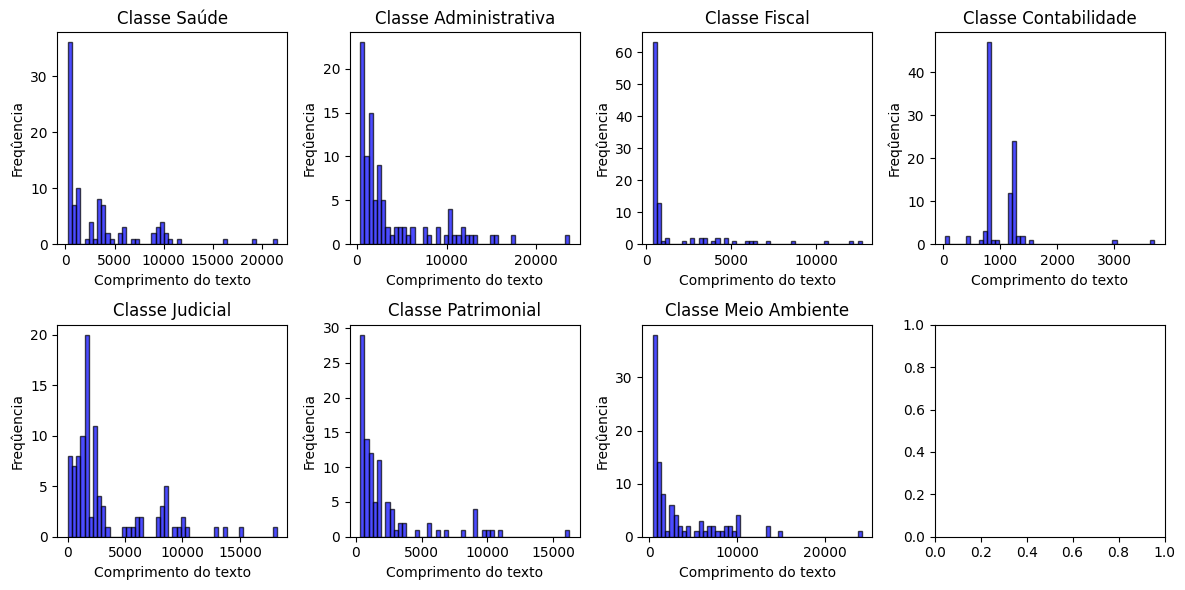

In [71]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
axs = axs.flatten()

data_info = {}

for i, classe in enumerate(setores_destino):
    subset = sampled_df[sampled_df['setorDestino'] == classe]['text_length']

    data_info[classe] = {'Média': int(subset.mean()),
                         'Máximo': int(subset.max()),
                         'Mínimo': int(subset.min()),
                         'Desvio Padrão': int(subset.std())}

    axs[i].hist(subset, bins=50, alpha=0.7, color='b', edgecolor='black')
    axs[i].set_title(f'Classe {classe}')
    axs[i].set_xlabel('Comprimento do texto')
    axs[i].set_ylabel('Freqûencia')

plt.tight_layout()
plt.show()

In [72]:
pd.DataFrame(data=data_info)

,Saúde,Administrativa,Fiscal,Contabilidade,Judicial,Patrimonial,Meio Ambiente
Média,3469,3992,1585,996,3467,2352,3209
Máximo,21518,23713,12682,3703,18223,16246,24141
Mínimo,252,373,364,28,28,337,372
Desvio Padrão,4208,4604,2493,432,3686,2994,4112
